### Simple Deep Q-Network Leanring

In [2]:
%matplotlib inline
import gym

import numpy as np
import math
import random
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import pandas as pd

### Custum env

In [23]:
"""classic Acrobot task"""
from typing import Optional

import numpy as np
from numpy import cos, pi, sin

from gym import core, logger, spaces
from gym.error import DependencyNotInstalled

__copyright__ = "Copyright 2013, RLPy http://acl.mit.edu/RLPy"
__credits__ = [
    "Alborz Geramifard",
    "Robert H. Klein",
    "Christoph Dann",
    "William Dabney",
    "Jonathan P. How",
]
__license__ = "BSD 3-Clause"
__author__ = "Christoph Dann <cdann@cdann.de>"

# # SOURCE:
# # https://github.com/rlpy/rlpy/blob/master/rlpy/Domains/Acrobot.py
from gym.envs.classic_control import utils


class CustomEnv(core.Env):
    """
    ### Description

    The Acrobot environment is based on Sutton's work in
    ["Generalization in Reinforcement Learning: Successful Examples Using Sparse Coarse Coding"](https://papers.nips.cc/paper/1995/hash/8f1d43620bc6bb580df6e80b0dc05c48-Abstract.html)
    and [Sutton and Barto's book](http://www.incompleteideas.net/book/the-book-2nd.html).
    The system consists of two links connected linearly to form a chain, with one end of
    the chain fixed. The joint between the two links is actuated. The goal is to apply
    torques on the actuated joint to swing the free end of the linear chain above a
    given height while starting from the initial state of hanging downwards.

    As seen in the **Gif**: two blue links connected by two green joints. The joint in
    between the two links is actuated. The goal is to swing the free end of the outer-link
    to reach the target height (black horizontal line above system) by applying torque on
    the actuator.

    ### Action Space

    The action is discrete, deterministic, and represents the torque applied on the actuated
    joint between the two links.

    | Num | Action                                | Unit         |
    |-----|---------------------------------------|--------------|
    | 0   | apply -1 torque to the actuated joint | torque (N m) |
    | 1   | apply 0 torque to the actuated joint  | torque (N m) |
    | 2   | apply 1 torque to the actuated joint  | torque (N m) |

    ### Observation Space

    The observation is a `ndarray` with shape `(6,)` that provides information about the
    two rotational joint angles as well as their angular velocities:

    | Num | Observation                  | Min                 | Max               |
    |-----|------------------------------|---------------------|-------------------|
    | 0   | Cosine of `theta1`           | -1                  | 1                 |
    | 1   | Sine of `theta1`             | -1                  | 1                 |
    | 2   | Cosine of `theta2`           | -1                  | 1                 |
    | 3   | Sine of `theta2`             | -1                  | 1                 |
    | 4   | Angular velocity of `theta1` | ~ -12.567 (-4 * pi) | ~ 12.567 (4 * pi) |
    | 5   | Angular velocity of `theta2` | ~ -28.274 (-9 * pi) | ~ 28.274 (9 * pi) |

    where
    - `theta1` is the angle of the first joint, where an angle of 0 indicates the first link is pointing directly
    downwards.
    - `theta2` is ***relative to the angle of the first link.***
        An angle of 0 corresponds to having the same angle between the two links.

    The angular velocities of `theta1` and `theta2` are bounded at ±4π, and ±9π rad/s respectively.
    A state of `[1, 0, 1, 0, ..., ...]` indicates that both links are pointing downwards.

    ### Rewards

    The goal is to have the free end reach a designated target height in as few steps as possible,
    and as such all steps that do not reach the goal incur a reward of -1.
    Achieving the target height results in termination with a reward of 0. The reward threshold is -100.

    ### Starting State

    Each parameter in the underlying state (`theta1`, `theta2`, and the two angular velocities) is initialized
    uniformly between -0.1 and 0.1. This means both links are pointing downwards with some initial stochasticity.

    ### Episode End

    The episode ends if one of the following occurs:
    1. Termination: The free end reaches the target height, which is constructed as:
    `-cos(theta1) - cos(theta2 + theta1) > 1.0`
    2. Truncation: Episode length is greater than 500 (200 for v0)

    ### Arguments

    No additional arguments are currently supported.

    ```
    env = gym.make('Acrobot-v1')
    ```

    By default, the dynamics of the acrobot follow those described in Sutton and Barto's book
    [Reinforcement Learning: An Introduction](http://incompleteideas.net/book/11/node4.html).
    However, a `book_or_nips` parameter can be modified to change the pendulum dynamics to those described
    in the original [NeurIPS paper](https://papers.nips.cc/paper/1995/hash/8f1d43620bc6bb580df6e80b0dc05c48-Abstract.html).

    ```
    # To change the dynamics as described above
    env.env.book_or_nips = 'nips'
    ```

    See the following note and
    the [implementation](https://github.com/openai/gym/blob/master/gym/envs/classic_control/acrobot.py) for details:

    > The dynamics equations were missing some terms in the NIPS paper which
            are present in the book. R. Sutton confirmed in personal correspondence
            that the experimental results shown in the paper and the book were
            generated with the equations shown in the book.
            However, there is the option to run the domain with the paper equations
            by setting `book_or_nips = 'nips'`


    ### Version History

    - v1: Maximum number of steps increased from 200 to 500. The observation space for v0 provided direct readings of
    `theta1` and `theta2` in radians, having a range of `[-pi, pi]`. The v1 observation space as described here provides the
    sine and cosine of each angle instead.
    - v0: Initial versions release (1.0.0) (removed from gym for v1)

    ### References
    - Sutton, R. S. (1996). Generalization in Reinforcement Learning: Successful Examples Using Sparse Coarse Coding.
        In D. Touretzky, M. C. Mozer, & M. Hasselmo (Eds.), Advances in Neural Information Processing Systems (Vol. 8).
        MIT Press. https://proceedings.neurips.cc/paper/1995/file/8f1d43620bc6bb580df6e80b0dc05c48-Paper.pdf
    - Sutton, R. S., Barto, A. G. (2018 ). Reinforcement Learning: An Introduction. The MIT Press.
    """

    metadata = {
        "render_modes": ["human", "rgb_array"],
        "render_fps": 15,
    }

    dt = 0.2

    LINK_LENGTH_1 = 1.0  # [m]
    LINK_LENGTH_2 = 1.0  # [m]
    LINK_MASS_1 = 1.0  #: [kg] mass of link 1
    LINK_MASS_2 = 1.0  #: [kg] mass of link 2
    LINK_COM_POS_1 = 0.5  #: [m] position of the center of mass of link 1
    LINK_COM_POS_2 = 0.5  #: [m] position of the center of mass of link 2
    LINK_MOI = 1.0  #: moments of inertia for both links

    MAX_VEL_1 = 4 * pi
    MAX_VEL_2 = 9 * pi

    AVAIL_TORQUE = [-1.0, 0.0, +1]

    torque_noise_max = 0.0

    SCREEN_DIM = 500

    #: use dynamics equations from the nips paper or the book
    book_or_nips = "book"
    action_arrow = None
    domain_fig = None
    actions_num = 3

    def __init__(self, render_mode: Optional[str] = None):
        self.render_mode = render_mode
        self.screen = None
        self.clock = None
        self.isopen = True
        high = np.array(
            [1.0, 1.0, 1.0, 1.0, self.MAX_VEL_1, self.MAX_VEL_2], dtype=np.float32
        )
        low = -high
        self.observation_space = spaces.Box(low=low, high=high, dtype=np.float32)
        self.action_space = spaces.Discrete(3)
        self.state = None

    def reset(self, *, seed: Optional[int] = None, options: Optional[dict] = None):
        super().reset(seed=seed)
        # Note that if you use custom reset bounds, it may lead to out-of-bound
        # state/observations.
        low, high = utils.maybe_parse_reset_bounds(
            options, -0.1, 0.1  # default low
        )  # default high
        self.state = self.np_random.uniform(low=low, high=high, size=(4,)).astype(
            np.float32
        )

        if self.render_mode == "human":
            self.render()
        return self._get_ob(), {}

    def step(self, a):
        s = self.state
        assert s is not None, "Call reset before using AcrobotEnv object."
        torque = self.AVAIL_TORQUE[a]

        # Add noise to the force action
        if self.torque_noise_max > 0:
            torque += self.np_random.uniform(
                -self.torque_noise_max, self.torque_noise_max
            )

        # Now, augment the state with our force action so it can be passed to
        # _dsdt
        s_augmented = np.append(s, torque)

        ns = rk4(self._dsdt, s_augmented, [0, self.dt])

        ns[0] = wrap(ns[0], -pi, pi)
        ns[1] = wrap(ns[1], -pi, pi)
        ns[2] = bound(ns[2], -self.MAX_VEL_1, self.MAX_VEL_1)
        ns[3] = bound(ns[3], -self.MAX_VEL_2, self.MAX_VEL_2)
        self.state = ns
        terminated = self._terminal()
        reward = -1.0 if not terminated else 0.0

        if self.render_mode == "human":
            self.render()
        return (self._get_ob(), reward, terminated, False, {})

    def _get_ob(self):
        s = self.state
        assert s is not None, "Call reset before using AcrobotEnv object."
        return np.array(
            [cos(s[0]), sin(s[0]), cos(s[1]), sin(s[1]), s[2], s[3]], dtype=np.float32
        )

    def _terminal(self):
        s = self.state
        assert s is not None, "Call reset before using AcrobotEnv object."
        return bool(-cos(s[0]) - cos(s[1] + s[0]) > 1.0)

    def _dsdt(self, s_augmented):
        m1 = self.LINK_MASS_1
        m2 = self.LINK_MASS_2
        l1 = self.LINK_LENGTH_1
        lc1 = self.LINK_COM_POS_1
        lc2 = self.LINK_COM_POS_2
        I1 = self.LINK_MOI
        I2 = self.LINK_MOI
        g = 9.8
        a = s_augmented[-1]
        s = s_augmented[:-1]
        theta1 = s[0]
        theta2 = s[1]
        dtheta1 = s[2]
        dtheta2 = s[3]
        d1 = (
            m1 * lc1**2
            + m2 * (l1**2 + lc2**2 + 2 * l1 * lc2 * cos(theta2))
            + I1
            + I2
        )
        d2 = m2 * (lc2**2 + l1 * lc2 * cos(theta2)) + I2
        phi2 = m2 * lc2 * g * cos(theta1 + theta2 - pi / 2.0)
        phi1 = (
            -m2 * l1 * lc2 * dtheta2**2 * sin(theta2)
            - 2 * m2 * l1 * lc2 * dtheta2 * dtheta1 * sin(theta2)
            + (m1 * lc1 + m2 * l1) * g * cos(theta1 - pi / 2)
            + phi2
        )
        if self.book_or_nips == "nips":
            # the following line is consistent with the description in the
            # paper
            ddtheta2 = (a + d2 / d1 * phi1 - phi2) / (m2 * lc2**2 + I2 - d2**2 / d1)
        else:
            # the following line is consistent with the java implementation and the
            # book
            ddtheta2 = (
                a + d2 / d1 * phi1 - m2 * l1 * lc2 * dtheta1**2 * sin(theta2) - phi2
            ) / (m2 * lc2**2 + I2 - d2**2 / d1)
        ddtheta1 = -(d2 * ddtheta2 + phi1) / d1
        return dtheta1, dtheta2, ddtheta1, ddtheta2, 0.0

    def render(self):
        if self.render_mode is None:
            logger.warn(
                "You are calling render method without specifying any render mode. "
                "You can specify the render_mode at initialization, "
                f'e.g. gym("{self.spec.id}", render_mode="rgb_array")'
            )
            return

        try:
            import pygame
            from pygame import gfxdraw
        except ImportError:
            raise DependencyNotInstalled(
                "pygame is not installed, run `pip install gym[classic_control]`"
            )

        if self.screen is None:
            pygame.init()
            if self.render_mode == "human":
                pygame.display.init()
                self.screen = pygame.display.set_mode(
                    (self.SCREEN_DIM, self.SCREEN_DIM)
                )
            else:  # mode in "rgb_array"
                self.screen = pygame.Surface((self.SCREEN_DIM, self.SCREEN_DIM))
        if self.clock is None:
            self.clock = pygame.time.Clock()

        surf = pygame.Surface((self.SCREEN_DIM, self.SCREEN_DIM))
        surf.fill((255, 255, 255))
        s = self.state

        bound = self.LINK_LENGTH_1 + self.LINK_LENGTH_2 + 0.2  # 2.2 for default
        scale = self.SCREEN_DIM / (bound * 2)
        offset = self.SCREEN_DIM / 2

        if s is None:
            return None

        p1 = [
            -self.LINK_LENGTH_1 * cos(s[0]) * scale,
            self.LINK_LENGTH_1 * sin(s[0]) * scale,
        ]

        p2 = [
            p1[0] - self.LINK_LENGTH_2 * cos(s[0] + s[1]) * scale,
            p1[1] + self.LINK_LENGTH_2 * sin(s[0] + s[1]) * scale,
        ]

        xys = np.array([[0, 0], p1, p2])[:, ::-1]
        thetas = [s[0] - pi / 2, s[0] + s[1] - pi / 2]
        link_lengths = [self.LINK_LENGTH_1 * scale, self.LINK_LENGTH_2 * scale]

        pygame.draw.line(
            surf,
            start_pos=(-2.2 * scale + offset, 1 * scale + offset),
            end_pos=(2.2 * scale + offset, 1 * scale + offset),
            color=(0, 0, 0),
        )

        for ((x, y), th, llen) in zip(xys, thetas, link_lengths):
            x = x + offset
            y = y + offset
            l, r, t, b = 0, llen, 0.1 * scale, -0.1 * scale
            coords = [(l, b), (l, t), (r, t), (r, b)]
            transformed_coords = []
            for coord in coords:
                coord = pygame.math.Vector2(coord).rotate_rad(th)
                coord = (coord[0] + x, coord[1] + y)
                transformed_coords.append(coord)
            gfxdraw.aapolygon(surf, transformed_coords, (0, 204, 204))
            gfxdraw.filled_polygon(surf, transformed_coords, (0, 204, 204))

            gfxdraw.aacircle(surf, int(x), int(y), int(0.1 * scale), (204, 204, 0))
            gfxdraw.filled_circle(surf, int(x), int(y), int(0.1 * scale), (204, 204, 0))

        surf = pygame.transform.flip(surf, False, True)
        self.screen.blit(surf, (0, 0))

        if self.render_mode == "human":
            pygame.event.pump()
            self.clock.tick(self.metadata["render_fps"])
            pygame.display.flip()

        elif self.render_mode == "rgb_array":
            return np.transpose(
                np.array(pygame.surfarray.pixels3d(self.screen)), axes=(1, 0, 2)
            )

    def close(self):
        if self.screen is not None:
            import pygame

            pygame.display.quit()
            pygame.quit()
            self.isopen = False


def wrap(x, m, M):
    """Wraps ``x`` so m <= x <= M; but unlike ``bound()`` which
    truncates, ``wrap()`` wraps x around the coordinate system defined by m,M.\n
    For example, m = -180, M = 180 (degrees), x = 360 --> returns 0.

    Args:
        x: a scalar
        m: minimum possible value in range
        M: maximum possible value in range

    Returns:
        x: a scalar, wrapped
    """
    diff = M - m
    while x > M:
        x = x - diff
    while x < m:
        x = x + diff
    return x


def bound(x, m, M=None):
    """Either have m as scalar, so bound(x,m,M) which returns m <= x <= M *OR*
    have m as length 2 vector, bound(x,m, <IGNORED>) returns m[0] <= x <= m[1].

    Args:
        x: scalar
        m: The lower bound
        M: The upper bound

    Returns:
        x: scalar, bound between min (m) and Max (M)
    """
    if M is None:
        M = m[1]
        m = m[0]
    # bound x between min (m) and Max (M)
    return min(max(x, m), M)


def rk4(derivs, y0, t):
    """
    Integrate 1-D or N-D system of ODEs using 4-th order Runge-Kutta.

    Example for 2D system:

        >>> def derivs(x):
        ...     d1 =  x[0] + 2*x[1]
        ...     d2 =  -3*x[0] + 4*x[1]
        ...     return d1, d2

        >>> dt = 0.0005
        >>> t = np.arange(0.0, 2.0, dt)
        >>> y0 = (1,2)
        >>> yout = rk4(derivs, y0, t)

    Args:
        derivs: the derivative of the system and has the signature ``dy = derivs(yi)``
        y0: initial state vector
        t: sample times

    Returns:
        yout: Runge-Kutta approximation of the ODE
    """

    try:
        Ny = len(y0)
    except TypeError:
        yout = np.zeros((len(t),), np.float_)
    else:
        yout = np.zeros((len(t), Ny), np.float_)

    yout[0] = y0

    for i in np.arange(len(t) - 1):

        this = t[i]
        dt = t[i + 1] - this
        dt2 = dt / 2.0
        y0 = yout[i]

        k1 = np.asarray(derivs(y0))
        k2 = np.asarray(derivs(y0 + dt2 * k1))
        k3 = np.asarray(derivs(y0 + dt2 * k2))
        k4 = np.asarray(derivs(y0 + dt * k3))
        yout[i + 1] = y0 + dt / 6.0 * (k1 + 2 * k2 + 2 * k3 + k4)
    # We only care about the final timestep and we cleave off action value which will be zero
    return yout[-1][:4]

#### load data

In [24]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [25]:
data = pd.read_csv("./data_saved/EURUSD_M1_2023.csv")

print(data.head(10))
print(data.describe())


# data = data.resample

data_tensor = torch.tensor(data[['close']].values, dtype=torch.float32).unsqueeze(0).to(device)  # Add batch dimension


data_tensor = data_tensor[:10000]

             timestamp     open     high      low    close
0  2023-01-01 17:05:00  1.06973  1.06978  1.06970  1.06970
1  2023-01-01 17:06:00  1.06966  1.06966  1.06966  1.06966
2  2023-01-01 17:08:00  1.06970  1.06974  1.06970  1.06970
3  2023-01-01 17:10:00  1.06975  1.06980  1.06972  1.06972
4  2023-01-01 17:11:00  1.06972  1.06972  1.06972  1.06972
5  2023-01-01 17:12:00  1.06975  1.06980  1.06975  1.06975
6  2023-01-01 17:13:00  1.07066  1.07066  1.06917  1.06917
7  2023-01-01 17:14:00  1.06937  1.06937  1.06899  1.06899
8  2023-01-01 17:15:00  1.06788  1.06788  1.06788  1.06788
9  2023-01-01 17:16:00  1.06788  1.06788  1.06788  1.06788
                open           high            low          close
count  322637.000000  322637.000000  322637.000000  322637.000000
mean        1.080758       1.080831       1.080684       1.080684
std         0.016279       0.016277       0.016282       0.016282
min         1.044930       1.044980       1.044830       1.044830
25%         1.068360 

In [26]:
# from envs import ForexEnv
# # env = gym.make("Acrobot-v1")
# env = ForexEnv(
#     df=data,
#     window_size=10,
#     frame_bound=(10, 300),
#     unit_side='right')

env = CustomEnv()

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# if GPU is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [27]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [28]:
class DQN(nn.Module):
    
    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, n_actions)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)

In [29]:
BATCH_SIZE = 128
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 1000
TAU = 0.005
LR = 1e-4

# Get number of actions from gym action space
n_actions = env.action_space.n
# Get the number of state observations
obj_state, info = env.reset()
print(obj_state, info)
n_observations = len(obj_state)

policy_net = DQN(n_observations, n_actions).to(device)
target_net = DQN(n_observations, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(10000)


steps_done = 0

[ 0.9953386   0.0964418   0.9977298   0.06734466  0.07038799 -0.05927397] {}


In [30]:
def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            # t.max(1) will return the largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            return policy_net(state).max(1).indices.view(1, 1)
    else:
        return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)


episode_durations = []


def plot_durations(show_result=False):
    plt.figure(1)
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())

In [31]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1).values
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1).values
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # In-place gradient clipping
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()

Complete


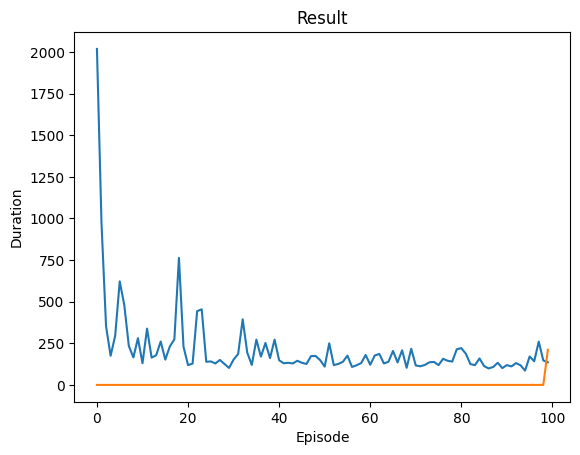

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [32]:
if torch.cuda.is_available():
    num_episodes = 100
else:
    num_episodes = 50

for i_episode in range(num_episodes):
    # Initialize the environment and get its state
    state, info = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    for t in count():
        action = select_action(state)
        observation, reward, terminated, truncated, _ = env.step(action.item())
        reward = torch.tensor([reward], device=device)
        done = terminated or truncated

        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the policy network)
        optimize_model()

        # Soft update of the target network's weights
        # θ′ ← τ θ + (1 −τ )θ′
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
        target_net.load_state_dict(target_net_state_dict)

        if done:
            episode_durations.append(t + 1)
            plot_durations()
            break

print('Complete')
plot_durations(show_result=True)
plt.ioff()
plt.show()